# CA5 Convolutional Neural Networks

**BrainTumorModel - A PyTorch Convolutional Neural Network for Brain Tumor Classification**

<html>
<div>
  <span style="font-family: Poppins; font-size:30px; color: black;"> <br/> University of Tehran <br/>
</div>
<span style="font-family: Poppins; font-size:15pt; color: black; vertical-align: middle;"> Mobina Mehrazar </span><br>
<span style="font-family: Poppins; font-size:15pt; color: black; vertical-align: middle;"> 810100216 </span>

</html>

In this project, the focus is on implementing a convolutional neural network (CNN) for image classification using the PyTorch framework.

The dataset used in this project consists of MRI brain images for the detection of various brain tumors, including images related to 4 classes: notumor, meningioma, glioma, and pituitary.

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor
import random
import torch
from google.colab import drive
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from termcolor import colored
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Introduction to the Dataset

In [2]:
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/AI-CA5-Dataset'

Mounted at /content/drive


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Learning Efficiency in Neural Networks: The Role of Feature Normalization

Normalization of a feature within a dataset is expressed through the following formula:

$X_{\text{normalized}} = \frac{{X - \mu}}{{\sigma}}$

Here, $X_{\text{normalized}}$​ signifies the normalized value of the feature, ${X}$ represents the original value of the feature, ${μ}$ denotes the mean (average) of the feature values, and ${σ}$ signifies the standard deviation of the feature values.

This formula is systematically applied to each pixel value within an image. Normalizing pixel values serves to center the input distribution around zero and adjusts the values based on their standard deviations. This process contributes to a more consistent and effective learning experience within neural networks.

`Advantages`:

Accelerated Convergence: Normalizing pixel values contributes to the improved convergence speed and stability of machine learning algorithms.

**Enhanced Model Performance:** By mitigating the influence of irrelevant pixel intensity variations, normalization aids models in capturing patterns and relationships within the data more effectively.

**Lighting Condition Mitigation:** The normalization process helps alleviate the impact of disparate lighting conditions in images.

**Algorithm Compatibility:** Certain machine learning algorithms, such as neural networks, exhibit enhanced performance when trained on normalized input data.

`Disadvantages`:

**Potential Information Loss:** Careless normalization may result in information loss. For instance, an excessively narrow normalization range can compress differences between pixel values, leading to a loss of fine-grained detail.

**Sensitivity to Outliers:** Normalization can be sensitive to outliers or extreme values present in the dataset.

**Task-Specific Considerations:** The choice of normalization method may depend on the specific requirements of the computer vision task at hand.

---

## Optimal Splitting of Dataset into Train and Test Sets: Ratio Selection and Rationale

In supervised machine learning, the division of the dataset into training and testing sets serves various essential purposes:

- Model Training: The training set is exclusively utilized to instruct the model. It forms the foundation upon which the machine learning algorithm operates, constructing a mathematical model in the process.

- Model Evaluation: Employing the testing set for model evaluation ensures an unbiased assessment of performance. Since this data is not involved in the training phase, it offers insights into how effectively the model generalizes to unseen data.

- Preventing Overfitting: The utilization of a distinct testing set helps safeguard against overfitting, where the model might memorize the training data but struggles to generalize to new, unseen data. This ensures a more robust and reliable model.

- Model Selection: The performance metrics derived from the test set play a pivotal role in comparing and selecting the most effective model when evaluating multiple models. This aids in making informed decisions regarding the model's suitability for the intended task.

In this code snippet, I employ the train_test_split function from the sklearn library to partition the dataset into distinct training and testing sets. Notably, the test_size parameter is configured to $0.2$, designating that $20%$ of the data is allocated for testing, while the remaining $80%$ is designated for training. Additionally, the stratify parameter is applied to guarantee that both the training and testing sets maintain a proportional representation of samples across each target class, mirroring the distribution of the complete dataset.

## Custom Dataset Class for Brain Tumor Images: Loading, Transforming, and Visualizing

In [4]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['pituitary', 'notumor', 'meningioma', 'glioma']
        self.files = []
        self.labels = []
        for class_index, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            class_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
            self.files += class_files
            self.labels += [class_index] * len(class_files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.files)

    def plot_sample_images(self):
        fig, axs = plt.subplots(1, len(self.classes), figsize=(15, 15))
        for i, class_name in enumerate(self.classes):
            class_files = [f for f in self.files if class_name in f]
            img_path = random.choice(class_files)
            image = Image.open(img_path).convert('L')
            if self.transform:
                image = self.transform(image)
            axs[i].imshow(image.permute(1, 2, 0), cmap='gray')
            axs[i].set_title(class_name)
            axs[i].axis('off')
        plt.show()

    def get_labels(self):
        return self.labels

## Brain Tumor Classification CNN Model: Feature Extraction and Classification Layers

`Kernel Size:`<br>
The kernel size within a convolutional layer denotes the dimensions of the filter employed to scan the input data. Its magnitude directly impacts feature extraction—larger kernels capture global features, while smaller ones focus on local patterns. This parameter significantly shapes the receptive field of convolution, influencing the model's proficiency in recognizing and extracting spatial hierarchies.

`Padding:`<br>
Padding, a critical parameter in convolutional layers, dictates the addition of extra pixels around input data, preventing the loss of spatial information during convolution. Well-chosen padding values ensure compatibility between input and output sizes, preserving the edges and details of the input. This contributes to the model's efficacy in extracting meaningful features by maintaining spatial integrity.

`Stride:`<br>
Stride defines the step size or the number of pixels the convolutional or pooling window traverses across input data. Adjusting the stride alters the spatial dimensions of the output—larger strides result in more aggressive down-sampling, while smaller strides facilitate finer-grained feature extraction, influencing the overlap between neighboring regions. Stride plays a pivotal role in balancing computational efficiency, model interpretability, and the preservation of spatial information.

---

`BrainTumorModel`, implemented in PyTorch, is a Convolutional Neural Network (CNN) tailored for brain tumor classification. The model comprises two main components: the features part and the classifier part.

**Features Part**

Responsible for extracting valuable features from input images, the features part is composed of a sequence of layers, including Convolutional Layers (`nn.Conv2d`), ReLU Activation Functions (`nn.ReLU`), and Pooling Layers (`nn.MaxPool2d` and `nn.AdaptiveAvgPool2d`).

1. **Convolutional Layers (`nn.Conv2d`):** These layers employ learnable filters to detect specific features in input images, such as edges or corners. A 3x3 filter is used, capturing local patterns. The `padding` parameter (set to 1) prevents spatial information loss during convolution.

2. **ReLU Activation Function (`nn.ReLU`):** Introducing non-linearity, the ReLU function is applied element-wise, replacing negative pixel values with zero, enabling the model to learn intricate patterns.

3. **Pooling Layers (`nn.MaxPool2d`):** Reducing spatial dimensions, these layers control computational complexity, mitigate overfitting, and consolidate features. A 2x2 kernel and stride of 2 govern the pooling operation.

4. **Adaptive Average Pooling (`nn.AdaptiveAvgPool2d`):** Downsampling input to a fixed size, this layer ensures a consistent spatial resolution (6x6 in this case) irrespective of the input size. It computes the average value within adaptively-sized pooling windows.

**Classifier Part**

The classifier part, a fully connected network, conducts the final classification, taking the features extracted by the features part.

1. **Linear Layers (`nn.Linear`):** Applying a linear transformation to incoming data, these layers reduce the high-dimensional feature vector to a space corresponding to the number of classes.

2. **ReLU Activation Function (`nn.ReLU`):** Introducing non-linearity once again, this function aids in learning complex decision boundaries.

**Forward Method**

The `forward` method defines the model's forward pass. Taking an input tensor (`x`), it passes through the features part for feature extraction, flattens the output, and then undergoes classification in the classifier part to produce the final output.

---

Optimizing Model Parameters and Hyperparameters:

`Increased num_channels`:<br>
Adjusting the number of channels is pivotal, with ties to data characteristics (e.g., RGB images having 3 channels). Arbitrary changes lack meaningful interpretation, emphasizing the need to align channel numbers with inherent data properties.

`More out_channels`:<br>
The introduction of additional output channels enhances the model's capacity to capture features. However, this improvement comes at the expense of increased computational demands and heightened model complexity. Striking a thoughtful trade-off is imperative for optimal performance.

`Larger kernel_size`:<br>
Enlarging the kernel size empowers the model to gather more contextual information. Nevertheless, this decision involves a trade-off, sharply reducing the feature map size. Achieving the right balance is crucial for maintaining optimal performance.

`Increasing padding`:<br>
Adjusting padding values plays a pivotal role, preserving feature map size and aiding in edge feature extraction. However, excessive padding may dilute feature intensity, necessitating careful consideration to prevent information loss or distortion.

`More hidden_units`:<br>
The expansion of hidden units facilitates the model in learning intricate patterns. However, this enhancement brings the risk of overfitting and incurs heightened computational costs. Balancing complexity and generalization is essential for optimal performance.

`Changing output_shape`:<br>
The output shape is dictated by the number of output classes. Arbitrary changes may misalign with the problem's demands, underscoring the importance of aligning the output shape with the specific requirements of the classification task.

In [5]:
class BrainTumorModel(nn.Module):
    def __init__(self):
        super(BrainTumorModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.AdaptiveAvgPool2d((6,6))
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 256),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 64),
            nn.LeakyReLU(inplace=True),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

## Visualizing Class Distribution and Performance Metrics in Brain Tumor Classification

In [6]:
def plot_class_distribution(dataset, title):
    labels = [dataset.dataset.classes[label] for _, label in dataset]
    counter = Counter(labels)
    plt.figure(figsize=(10, 5))
    plt.bar(counter.keys(), counter.values())

    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.show()

def plot_confusion_matrix(confusion_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(5, 3.5))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_metrics_over_epochs(training_metrics, test_metrics, num_epochs, title, yLabel):
    plt.figure(figsize=(8,5))
    plt.plot(range(num_epochs), training_metrics, label='Training Metric')
    plt.plot(range(num_epochs), test_metrics, label='Test Metric')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(yLabel)
    plt.legend()
    plt.show()

def plot_loss_and_accuracy_over_epochs(num_epochs, train_losses, train_accuracies, test_losses, test_accuracies):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()

## Creating dataset

In [ ]:
def compute_dataset_mean_std(image_loader):
    cumulative_mean = 0.
    cumulative_variance = 0.
    total_image_count = 0

    for images, _ in image_loader:
        images = images.to(device)
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)
        cumulative_mean += images.mean(2).sum(0)
        cumulative_variance += images.pow(2).sum(2).sum(0)
        total_image_count += batch_size

    overall_mean = cumulative_mean / total_image_count
    overall_std = (cumulative_variance / total_image_count - overall_mean ** 2) ** 0.5

    return overall_mean, overall_std

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

dataset = BrainTumorDataset(root_dir=dataset_path, transform=transform)
image_loader = DataLoader(dataset, batch_size=32, shuffle=False)
dataset_mean, dataset_std = compute_dataset_mean_std(image_loader)

dataset_mean_list = list(dataset_mean.numpy())
print(f"dataset_mean_list = {dataset_mean_list}")
dataset_std_list = list(dataset_std.numpy())
print(f"dataset_std_list = {dataset_std_list}")

image_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2),
                           saturation=(0.8, 1.2), hue=0.25),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean_list, std=dataset_std_list)
])

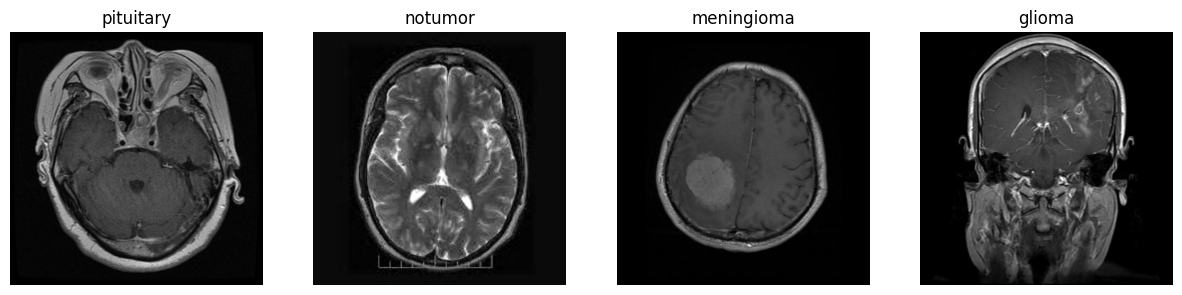

In [8]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2),
                           saturation=(0.8, 1.2), hue=0.25),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.445, std=0.269),
])

dataset = BrainTumorDataset(root_dir=dataset_path, transform=transform)
dataset.plot_sample_images()

In [9]:
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=dataset.get_labels(), random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

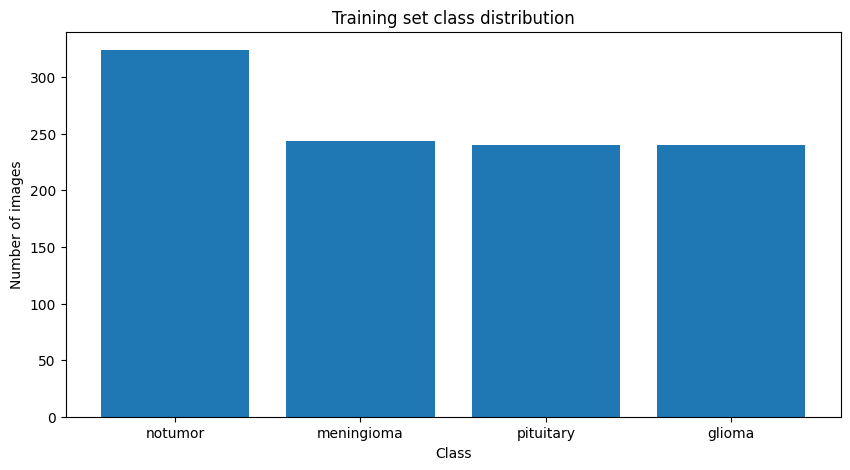

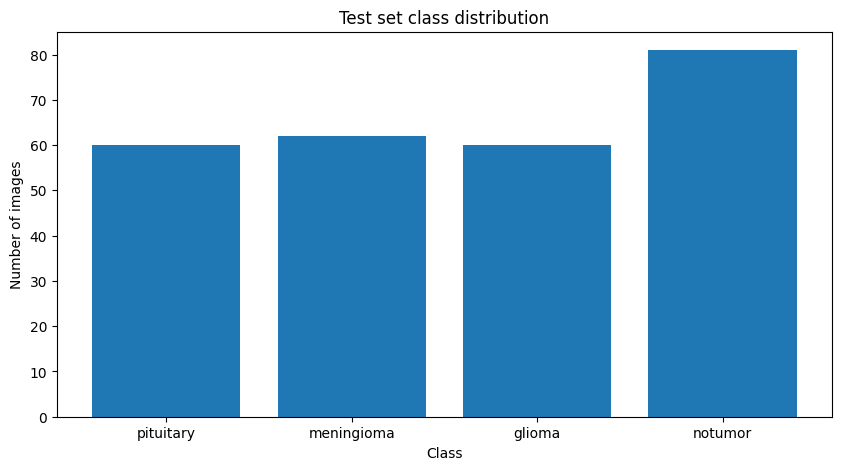

In [21]:
plot_class_distribution(train_dataset, 'Training set class distribution')
plot_class_distribution(test_dataset, 'Test set class distribution')

## Exploring the Significance of Batch Size Parameter in the Training Process: Impacts and Considerations

The batch size dictates the number of training examples processed simultaneously during each training iteration. In your project, a batch size of 32 has been chosen for both training and testing data loaders, implying that the model processes 32 examples at a time during both these phases.

**Impact of Batch Size on Training:**

- Memory Usage:<br>
Small Batches: Economical memory use, suitable for resource constraints.<br>
Large Batches: Memory-intensive but optimized for advanced matrix operations.<br>
<br>
- Model Performance and Generalization:<br>
Small Batches: Introduce noise for potential stronger generalization but less stable training.<br>
Large Batches: Stable error gradient, potentially converging to sharp minimizers affecting generalization.<br>
<br>
- Computational Efficiency:<br>
Small Batches: Thorough exploration but may take longer to converge.<br>
Large Batches: Longer iteration time but potentially quicker convergence.<br>
<br>
- Convergence Speed:<br>
Small Batches: Escaping local minima due to gradient noise.<br>
Large Batches: Smoothing effect, but may get stuck in local minima.<br>
<br>
- Parallelism Use:<br>
Larger batches favor parallelization, enhancing CPU/GPU efficiency for faster training.<br>

---

**Drawbacks of Normalization in Image Processing:**

- Loss of Some Information:<br>
Issue: Global normalization may overlook critical image contrast, impacting content comprehension.<br>

- Complexity:<br>
Challenge: Introducing additional processing steps can complicate the data pipeline, especially when diverse images demand varied normalization methods.<br>

- Parameter Dependence:<br>
Concern: If normalization relies on specific parameters (e.g., training set mean and standard deviation), proper preservation and application during inference become essential, introducing an extra layer of complexity.<br>

- Potential Artifacts:<br>
Risk: Naive or aggressive normalization approaches might induce artifacts in processed images, altering their characteristics and potentially influencing model training negatively.<br>

- Requirement of Domain Knowledge:<br>
Challenge: Selecting the appropriate normalization method, such as local vs global normalization, may necessitate domain-specific insights. Incorrect choices could detrimentally affect the model's performance.<br>

---

**Selecting the Right Batch Size:**

Requires experimentation, as the ideal size varies with the dataset and network architecture.<br>

Commonly, powers of 2 are favored for efficient memory handling.<br>

---

**Additional Considerations:**

Batch Size vs. Learning Rate: Large batches may need different learning rates, with potential benefits from linear scaling.

Training Stability: Very large batches can induce instability, particularly without appropriate learning rate scaling.

In [11]:
training_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Exploring Different Activation Functions: Understanding Variances and the Rationale for Choosing Each in Your Neural Network

The CrossEntropyLoss function in PyTorch computes the cross entropy loss between the input logits and the target, which is useful when training a classification problem with C classes.
The input to CrossEntropyLoss is expected to contain raw, unnormalized scores (also known as logits) for each class. The target input should contain class indices.

The CrossEntropyLoss function applies the softmax function to the logits to convert them into probabilities, then computes the negative log likelihood loss. This is equivalent to applying the LogSoftmax function followed by the NLLLoss.
The loss for input vector x and class c is computed as:

$loss(x, class) = -x[class] + log\left(\sum_{j=1}^{C} exp(x[j])\right)$

where C is the number of classes.
If the optional argument weight is provided, it should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set.
The reduction parameter specifies the reduction to apply to the output: 'none' | 'mean' | 'sum'. By default, 'mean' is used, which returns the mean loss over the mini-batch.

Using CrossEntropyLoss in PyTorch has the advantage of numerical stability, as it internally applies the log-sum-exp trick to avoid numerical underflow or overflow caused by the softmax function.

---

Cross-Entropy loss stands out as a preferred choice for image classification tasks employing Convolutional Neural Networks (CNNs) due to its distinct advantages:

- **Probabilistic Interpretation**:<br> Cross-Entropy loss gives a probabilistic interpretation of the model’s predictions by converting the raw output scores (logits) into probabilities using the softmax function. This is particularly useful for multi-class classification problems, where each class’s probability needs to be computed.

- **Emphasizes Confident and Correct Predictions**:<br> Cross-Entropy loss heavily penalizes confident and wrong predictions. This means that if the model confidently predicts the wrong class, the loss will be large.

- **Stable Training**:<br> Cross-Entropy loss, combined with softmax, is more numerically stable. This is because it uses the log-sum-exp trick to avoid numerical underflow or overflow caused by the softmax function.

- **Efficient Optimization**:<br> It has been found to result in faster convergence and better performance of the network compared to other loss functions like Mean Squared Error (MSE).

- **Suitability for Classification Tasks**:<br> It measures the dissimilarity between the predicted probability distribution and the true distribution.
---
In the code, PyTorch’s CrossEntropyLoss function is used, which combines a softmax operation on the input and then applies the Negative Log-Likelihood Loss1.

## Understanding Adam Optimizer: Adaptive Moment Estimation in Deep Learning

The Adam optimizer combines the concepts of momentum and adaptive learning rates to efficiently update the model's parameters during training. The primary goal of Adam is to find the optimal values of the model's parameters that minimize the loss function.

`This is how it works :`<br>
Adam initializes the first and second moments' variables, m and v to zero. These variables keep track of the exponentially decaying average of past gradients and the exponentially decaying average of past squared gradients.<br>
<br>
The gradients of the model's parameters with respect to the loss function are computed using backpropagation.<br>
<br>
The first moment, m, is updated by exponentially decaying averages of the gradients. The second moment, v, is updated by exponentially decaying averages of the squared gradients. The decay rates are controlled by the hyperparameters beta1 and beta2, respectively.<br>
<br>
Since the moments m and v are initialized as zero, they are biased towards zero, particularly in the first few iterations. To counteract this bias, Adam performs bias correction by dividing the moments by factors of 1 - beta1 and 1 - beta2, respectively.<br>
<br>
Finally, Adam updates the model's parameters using the calculated moments and the learning rate. The learning rate is multiplied by the square root of the bias-corrected v, and the resulting value is divided by the biased-corrected m. This update rule allows for adaptive learning rates for each parameter.

`Differences from SGD :`<br>
- **Adaptive learning rate**:<br> SGD, which uses a fixed learning rate for all parameters, wheras Adam adapts the learning rate for each parameter. This adaptiveness can speed up convergence and improve overall performance.

- **Momentum**:<br> Adam combines adaptive learning rates with momentum-like behavior using the first moment, m. This combination enables Adam to converge faster and handle sparse gradients effectively.

- **Additional hyperparameters**:<br> Adam introduces two hyperparameters, beta1 and beta2, which control the decay rates of the first and second moments. These hyperparameters need to be fine-tuned to achieve optimal performance.

## Comparative Analysis of Stochastic Gradient Descent and Adam Optimization Algorithms in Neural Network Training

- **Update Rule**:<br>
SGD:<br>Updates model parameters along the negative gradient of the loss function.<br>
Adam:<br>Considers both the average of past gradients and past squared gradients, adapting the learning rate for each weight.

- **Learning Rate**:<br>
SGD:<br>Utilizes a constant or manually decayed learning rate.<br>
Adam:<br>Implements an adaptive learning rate, computing individual rates for different parameters.

- **Convergence Speed and Performance**:<br>
Adam:<br>tends to converge faster due to its adaptive learning rate.
SGD:<br>can converge to more optimal solutions with ample time and tuning.

- **Noise Handling**:<br>
SGD:<br>More robust to noise.<br>
Adam:<br>Sensitive to noise but excels in handling sparse gradients and non-stationary objectives.

- **Memory Requirement**:<br>
Adam demands more memory due to maintaining moving averages for each parameter.

## Unraveling Loss Functions in Neural Network Training

Cost functions, also referred to as loss functions, play a pivotal role in shaping the training of neural networks by quantifying the disparity between predicted and actual values. This report delves into various cost functions, elucidating their functionalities, applications, and the rationale guiding the selection of a final cost function.
---
- 1. Mean Squared Error (MSE) Loss:<br>
`How it Works`: Averages the squared difference between predicted and actual values.<br>
<br>
`Applications`: Predominantly for regression tasks with continuous output predictions.<br>
<br>
`Why Choose It`: Effectively penalizes larger errors, crucial for certain regression scenarios.<br>
<br>
$$MSE = \frac{1}{n} \sum_{i=1}^{n} ( predicted_i - target_i )^2$$
---
- 2. Cross-Entropy Loss (Log Loss):<br>
`How it Works`: Measures performance in classification models, increasing with divergence from actual labels.<br>
<br>
`Applications`: Ubiquitous in classification tasks, both binary and multi-class.<br>
<br>
`Why Choose It`: Well-suited for probability-based outputs, imparting a substantial penalty for confidently incorrect predictions.
<br>
$$CrossEntropy = - \sum_{i=1}^{C} target_i \log(predicted_i)$$
---
- 3. Binary Cross-Entropy Loss:<br>
`How it Works`: Specialized for binary classification, calculating loss for each label.<br>
<br>
`Applications`: Ideal for scenarios with only two label classes, e.g., spam vs. not-spam.<br>
<br>
`Why Choose It`: Effective when dealing with binary outcome probabilities.<br>
<br>
$$BCE = - \left( target* \log(predicted) + (1 - target) \log(1 - predicted) \right)$$
---
- 4. Negative Log-Likelihood Loss:<br>
`How it Works`: Used with log-probability outputs, minimized when correct class probability is maximized.<br>
<br>
`Applications`: Common in classification tasks with softmax activation.<br>
<br>
`Why Choose It`: Stability in convergence, especially with multinomial distributions.<br>
<br>
$$NLLLoss = - \log(predicted_{target})$$
---
- 5. Hinge Loss:<br>
`How it Works`: Tailored for binary classification, emphasizing "maximum-margin" classification.<br>
<br>
`Applications`: Frequent in SVMs and binary classification within neural networks.<br>
<br>
`Why Choose It`: Encourages confident and correct predictions, penalizing uncertainty.<br>
---
- 6. Categorical Cross-Entropy Loss:<br>
`How it Works`: An extension for multi-class classification tasks from binary cross-entropy loss.<br>
<br>
`Applications`: Suitable for scenarios with two or more label classes using one-hot encoding.<br>
<br>
`Why Choose It`: Effective in multi-class classification problems.<br>
---
- 7. Kullback-Leibler (KL) Divergence Loss:<br>
`How it Works`: Measures divergence between probability distributions.<br>
<br>
`Applications`: Common in variational autoencoders (VAEs) and scenarios aiming to match a particular distribution.<br>
<br>
`Why Choose It`: Applicable when there's a known target distribution to match.<br>
---

**Choosing a Loss Function:**

This selection depends on the characteristics of the problem.<br>
- For regression, **MSE** or **MAE** might be suitable.<br>
- In classification, **cross-entropy** losses excel with probability distributions.<br>
- **Hinge loss** is apt for tasks requiring confident and accurate predictions.<br>
- Specialized losses like **KL** divergence serve specific objectives.<br>
<br>
The ultimate choice of the cost function in a Convolutional Neural Network (CNN) should harmonize with the model's architecture. It must ensure precise predictions while upholding computational stability and efficiency throughout the training process.

## Train and Test

In [19]:
def evaluate_model(model, data_loader, loss_function):
    true_labels = []
    predicted_labels = []
    loss_amount = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            del inputs
            loss = loss_function(outputs, labels)
            loss_amount = loss.item()
            _, predicted = torch.max(outputs.data, 1)
            del outputs
            true_labels.extend(labels.cpu().numpy())
            del labels
            predicted_labels.extend(predicted.cpu().numpy())
    return true_labels, predicted_labels, loss_amount

def train_model(model, data_loader, optimizer, loss_function):
    true_labels = []
    predicted_labels = []
    loss_amount = 0.0
    for i, (inputs, labels) in enumerate(data_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        del inputs
        loss = loss_function(outputs, labels)
        loss.backward()
        loss_amount = loss.item()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        del outputs
        true_labels.extend(labels.cpu().numpy())
        del labels
        predicted_labels.extend(predicted.cpu().numpy())
    return true_labels, predicted_labels, loss_amount

epoch 9 / 30
Train:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       240
           1       0.75      0.85      0.80       324
           2       0.65      0.41      0.50       244
           3       0.68      0.80      0.73       240

    accuracy                           0.73      1048
   macro avg       0.72      0.72      0.71      1048
weighted avg       0.72      0.73      0.72      1048

Test:
              precision    recall  f1-score   support

           0       0.88      0.72      0.79        60
           1       0.70      0.89      0.78        81
           2       0.59      0.37      0.46        62
           3       0.69      0.83      0.76        60

    accuracy                           0.71       263
   macro avg       0.72      0.70      0.70       263
weighted avg       0.71      0.71      0.70       263

epoch 19 / 30
Train:
              precision    recall  f1-score   support

           0       0.92     

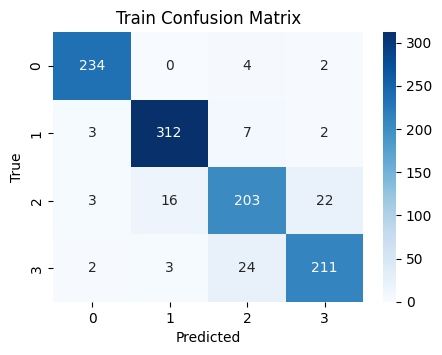

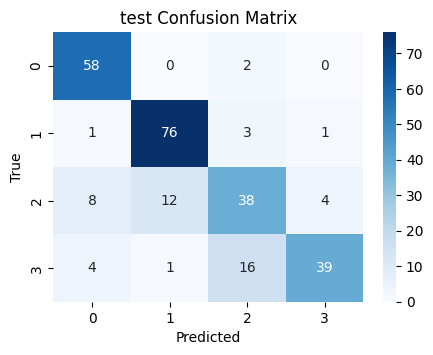

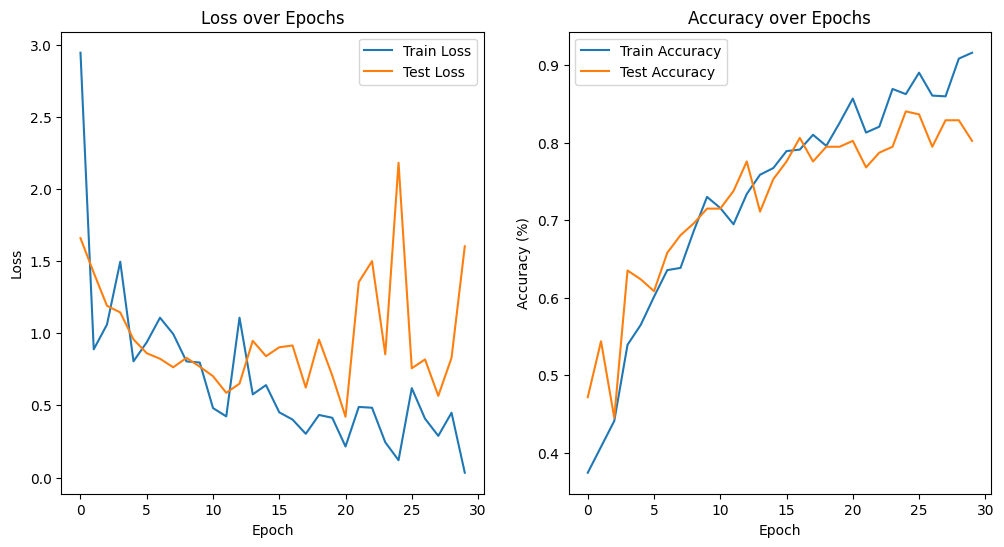

In [20]:
num_epochs = 30
model = BrainTumorModel()
model = model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
training_losses = []
test_losses = []
training_acc = []
test_acc = []

for epoch in range(num_epochs):
    model.train()

    train_true_labels, train_predicted_labels, training_loss_amount = train_model(model, training_data_loader, optimizer, loss_function)
    train_confusion_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
    train_accuracy = accuracy_score(train_true_labels, train_predicted_labels)
    training_losses.append(training_loss_amount)
    training_acc.append(train_accuracy)

    model.eval()

    test_true_labels, test_predicted_labels, test_loss_amount = evaluate_model(model, test_data_loader, loss_function)
    test_confusion_matrix = confusion_matrix(test_true_labels, test_predicted_labels)
    test_accuracy = accuracy_score(test_true_labels, test_predicted_labels)

    test_losses.append(test_loss_amount)
    test_acc.append(test_accuracy)

    if epoch % 10 == 9 or epoch == num_epochs-1:
        print(f'epoch {epoch} / {num_epochs}')
        print(f'Train:')
        print(classification_report(train_true_labels, train_predicted_labels))
        print(f'Test:')
        print(classification_report(test_true_labels, test_predicted_labels))
        if epoch != num_epochs-1:
            continue
        plot_confusion_matrix(train_confusion_matrix, 'Train Confusion Matrix')
        plot_confusion_matrix(test_confusion_matrix, 'test Confusion Matrix')
        plot_loss_and_accuracy_over_epochs(num_epochs, training_losses, training_acc, test_losses, test_acc)

## Regularization

- **BatchNorm2d**:<br>
Batch Normalization (BN) is a technique that normalizes the activations of each layer in a neural network by adjusting and scaling them.

The process of normalization in this method is:

1. Compute the mean and variance of the activations in the mini-batch.
2. Normalize the activations by subtracting the mean and dividing by the standard deviation.
3. Scale and shift the normalized activations by learnable parameters called gamma and beta, respectively.

The main benefits are:

**Improving network training speed:**<br> By normalizing the inputs, it helps to stabilize and speed up the convergence of the network.<br><br>
**Reducing sensitivity to the initialization:**<br> Batch Normalization reduces the dependence of the network on the initial parameter values.<br><br>
**Regularization effect:**<br> It adds a regularization effect and reduces overfitting to some extent.<br>
<br>
In the model, nn.BatchNorm2d(32) normalizes the output from the preceding layer which has 32 feature maps.

---

- **Dropout**:<br>
Dropout is a regularization technique that randomly sets a fraction of input units (neurons) to zero during the forward pass of training. This means that the selected neurons are "dropped out" or temporarily removed from the network. This act happens based on a probability.

The process of this method is:

During training, the dropout process is applied independently to each training example in each forward pass. In each pass, a new network is created by randomly dropping out neurons, and the gradients are backpropagated only through the active neurons. During inference or testing, the entire network is used, but the weights of the neurons are scaled by the dropout rate to account for the fact that more neurons are active during inference than during training.

The main benefits are:

**Regularization:** <br>Dropout acts as a form of regularization and It helps to reduce overfitting and makes the network more robust.<br><br>
**Improving generalization:** <br>By randomly dropping out neurons, Dropout forces the network to learn redundant representations and prevents it from relying too heavily on specific features aiming for a more generalized network.<br>
<br>
In the model, nn.Dropout(p=0.25) randomly zeros some of the elements of the input tensor with probability p using samples from a Bernoulli distribution.<br>
<br>
<br>

---

Both of these techniques are used to prevent overfitting of the model on the training data and help the model generalize better to unseen data.

## Reqularized BrainTumorModel

**Convolutional Layers in CNNs:**

Convolutional layers are fundamental elements in CNNs, applying learnable filters to input images to extract features, evolving from simple edges to intricate patterns through hierarchical representation.

- **Adjusting Convolutional Layer Depth**:<br>
The depth of a CNN denotes the stacking of convolutional layers. Augmenting this depth can improve the model's capability to comprehend intricate features, but it necessitates a careful balance:

- **Reasons for Layer Adjustment**:<br>
Increased depth facilitates the learning of hierarchical data representations.

Excessive layers may lead to overfitting, especially with limited data.

Deeper layers spatially condense information, progressing from pixel-level
details to abstract concepts.

- **Understanding Depth in CNN Architecture**:<br>
"Depth" can signify both the number of layers and the channels (feature maps) within each layer. Considering depth involves navigating trade-offs:

- **Advantages of Increased Depth**:<br>
**Deeper networks** potentially capture more **complex features**, enhancing performance.

Challenges such as **vanishing gradients** are mitigated by techniques like skip connections and batch normalization.

Greater channel depth enables the network to discern a broader spectrum of features.

In [14]:
import torch.nn as nn

class BrainTumorModel(nn.Module):
    def __init__(self):
        super(BrainTumorModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 64 * 64, 256),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, 64),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(inplace=True),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [15]:
del model

epoch 9 / 30
Train:
              precision    recall  f1-score   support

           0       0.74      0.78      0.75       240
           1       0.75      0.76      0.75       324
           2       0.50      0.27      0.36       244
           3       0.54      0.75      0.63       240

    accuracy                           0.65      1048
   macro avg       0.63      0.64      0.62      1048
weighted avg       0.64      0.65      0.63      1048

Test:
              precision    recall  f1-score   support

           0       0.60      0.98      0.74        60
           1       0.74      0.83      0.78        81
           2       0.73      0.13      0.22        62
           3       0.70      0.73      0.72        60

    accuracy                           0.68       263
   macro avg       0.69      0.67      0.62       263
weighted avg       0.70      0.68      0.63       263

epoch 19 / 30
Train:
              precision    recall  f1-score   support

           0       0.89     

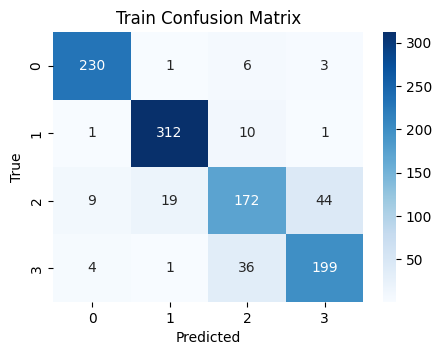

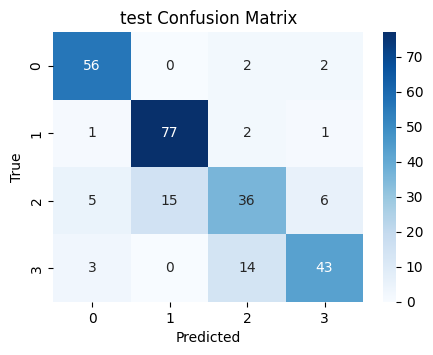

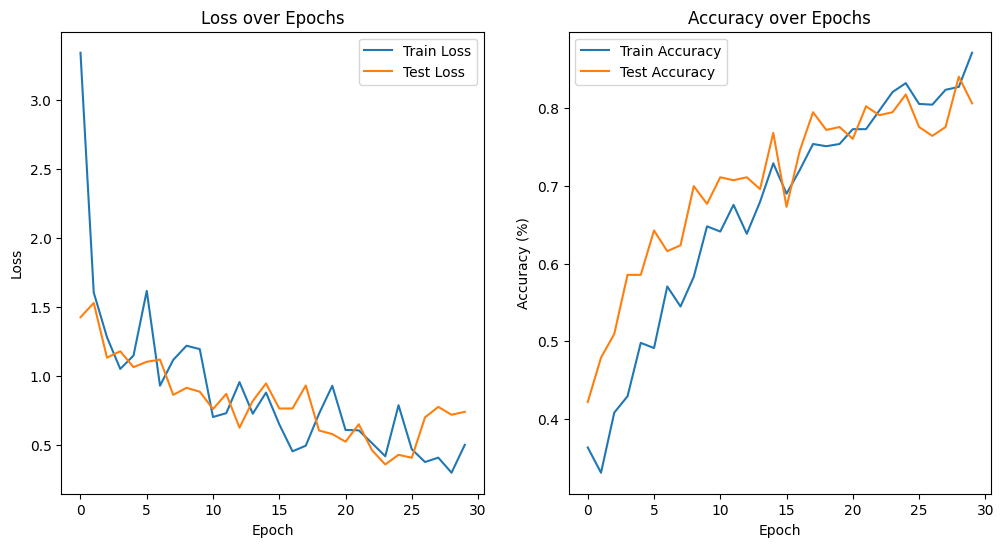

In [16]:
model = BrainTumorModel()
model = model.to(device)


num_epochs = 30
model = BrainTumorModel()
model = model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
training_losses = []
test_losses = []
training_acc = []
test_acc = []

for epoch in range(num_epochs):
    model.train()

    train_true_labels, train_predicted_labels, training_loss_amount = train_model(model, training_data_loader, optimizer, loss_function)
    train_confusion_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
    train_accuracy = accuracy_score(train_true_labels, train_predicted_labels)
    training_losses.append(training_loss_amount)
    training_acc.append(train_accuracy)

    model.eval()

    test_true_labels, test_predicted_labels, test_loss_amount = evaluate_model(model, test_data_loader, loss_function)
    test_confusion_matrix = confusion_matrix(test_true_labels, test_predicted_labels)
    test_accuracy = accuracy_score(test_true_labels, test_predicted_labels)

    test_losses.append(test_loss_amount)
    test_acc.append(test_accuracy)

    if epoch % 10 == 9 or epoch == num_epochs-1:
        print(f'epoch {epoch} / {num_epochs}')
        print(f'Train:')
        print(classification_report(train_true_labels, train_predicted_labels))
        print(f'Test:')
        print(classification_report(test_true_labels, test_predicted_labels))
        if epoch != num_epochs-1:
            continue
        plot_confusion_matrix(train_confusion_matrix, 'Train Confusion Matrix')
        plot_confusion_matrix(test_confusion_matrix, 'test Confusion Matrix')
        plot_loss_and_accuracy_over_epochs(num_epochs, training_losses, training_acc, test_losses, test_acc)

In [18]:
del model